<a href="https://colab.research.google.com/github/JSJeong-me/KOSA_GPT_RPA/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning with Visual Attention

## Learning Objectives
1. Learn how to create an image captioning model
2. Learn how to train and predict a text generation model.

Image captioning models take an image as input, and output text. Ideally, we want the output of the model to accurately describe the events/things in the image, similar to a caption a human might provide. <br>
For example, given an image like the example below, the model is expected to generate a caption such as *"some people are playing baseball."*.

<div><img src="../sample_images/baseball.jpeg" width="500"></div>

In order to generate text, we will build an encoder-decoder model, where the encoder output embedding of an input image, and the decoder output text from the image embedding<br>

I this notebook, we will use the model architecture similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), and build Attention-based image captioning model.

This notebook is an end-to-end example. The training dataset is the COCO large-scale object detection, segmentation, and captioning dataset.


In [ ]:
!pip install tf-models-official

In [ ]:
!pip install tensorflow-text==2.13

In [3]:
!pip install tensorflow-model-optimization

## Preparation

In [4]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

print(tf.version.VERSION)

2.13.0


## Read and prepare dataset

We will use the TensorFlow datasets capability to read the [COCO captions](https://www.tensorflow.org/datasets/catalog/coco_captions) dataset.
This version contains images, bounding boxes, labels, and captions from COCO 2014, split into the subsets defined by Karpathy and Li (2015) and takes
care of some data quality issues with the original dataset (for example, some
of the images in the original dataset did not have captions)

First, let's define some constants.<br>
In this lab, we will use a pretrained [InceptionResNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2/InceptionResNetV2) model from `tf.keras.applications` as a feature extractor, so some constants are comming from the InceptionResNetV2 model definition.<br>
So if you want to use other type of base model, please make sure to change these constants as well.

`tf.keras.applications` is a pretrained model repository like [TensorFlow Hub](https://tfhub.dev), but while Tensorflow Hub hosts models for different modalities including image, text, audio, and so on, `tf.keras.application` only hosts popular and stable models for images.<br>
However, `tf.keras.applications` is more flexible as it contains model metadata and it allow us to access and control the model behavior, while most of the TensorFlow Hub based models that only contains compiled SavedModels.<br>
So, for example, we can get output not only from the final layer of the model (e.g. flattend 1D Tensor output of CNN models), but also from intermediate layers (e.g. intermediate 3D Tensor) by accessing layer metadata.

In [5]:
# Change these to control the accuracy/speed
VOCAB_SIZE = 20000  # use fewer words to speed up convergence
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128

# InceptionResNetV2 takes (299, 299, 3) image as inputs
# and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

219055592/219055592 [==============================] - 1s 0us/step


### Filter and Preprocess
Here we preprocess the dataset. The function below:
- resize image to (`IMG_HEIGHT`, `IMG_WIDTH`) shape
- rescale pixel values from [0, 255] to [0, 1]
- return image(`image_tensor`) and captions(`captions`) dictionary.

**Note**: This dataset is too large to store in an local environment. Therefore, It is stored in a public GCS bucket located in us-central1.
So if you access it from a Notebook outside the US, it will be (a) slow and (b) subject to a network charge.

In [6]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000


def get_image_label(example):
    caption = example["captions"]["text"][0]  # only the first caption per image
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "caption": caption}


trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

trainds = trainds.map(
    get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

### Visualize
Let's take a look at images and sample captions in the dataset.

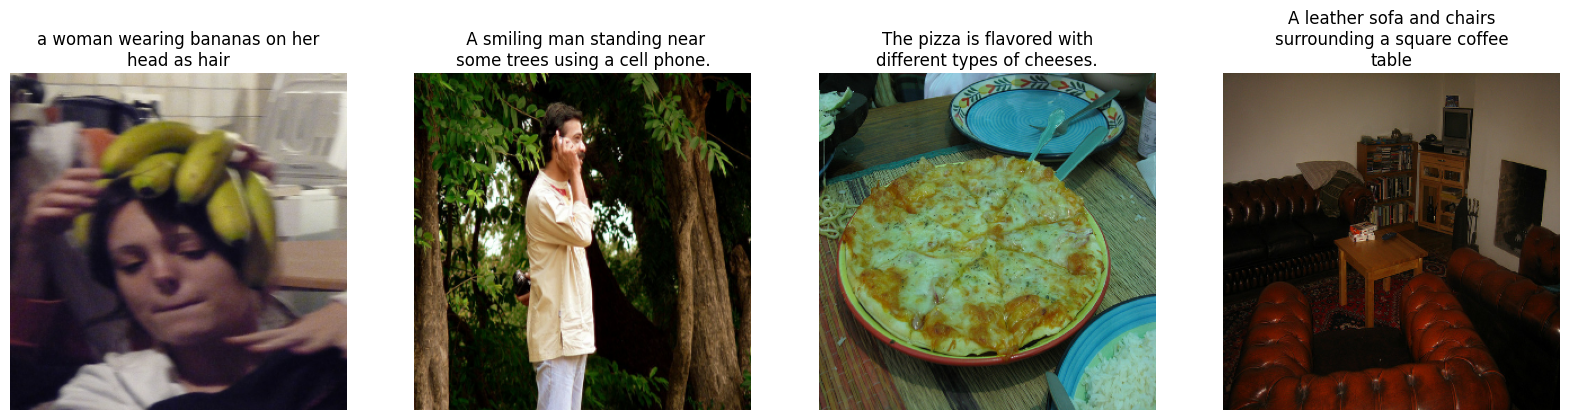

In [7]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

## Text Preprocessing

We add special tokens to represent the starts (`<start>`) and the ends (`<end>`) of sentences.<br>
Start and end tokens are added here because we are using an encoder-decoder model and during prediction, to get the captioning started we use `<start>` and since captions are of variable length, we terminate the prediction when we see the `<end>` token.

Then create a full list of the captions for further preprocessing.

In [8]:
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start>")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join(
        [start, data["caption"], end], separator=" "
    )
    return data


trainds = trainds.map(add_start_end_token)

## Preprocess and tokenize the captions

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top `VOCAB_SIZE` words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to the length `MAX_CAPTION_LEN`. Here we directly specify `64` number which is sufficient for this dataset, but please note that this value should be computed by processing the entire dataset if you don't want to cut down very long sentense in a dataset.

**Note**: This process takes around 5 minutes.

In [9]:
MAX_CAPTION_LEN = 64


# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))


Let's try to tokenize a sample text

In [10]:
tokenizer(["<start> This is a sentence <end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  3, 165,  11,   2,   1,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [11]:
sample_captions = []
for d in trainds.take(5):
    sample_captions.append(d["caption"].numpy())

In [12]:
sample_captions

[b'<start> a vintage photo of a man washing a lamb <end>',
 b'<start> there is a man that is throwing a frisbee <end>',
 b'<start> The young man is posing with his skateboard.  <end>',
 b'<start> A pile of broccoli on top of a pile of cauliflower. <end>',
 b'<start> A fire hydrant at a intersection at night. <end>']

In [13]:
print(tokenizer(sample_captions))

tf.Tensor(
[[   3    2  707  190    5    2   12 1654    2 1508    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3   79   11    2   12   28   11  459    2  116    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    7   39   12   11  328    9   50   81    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

Please note that all the sentenses starts and ends with the same token (e.g. '3' and '4'). These values represent start tokens and end tokens respectively.

You can also convert ids to original text.

In [14]:
for wordid in tokenizer([sample_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")

<start> a vintage photo of a man washing a lamb <end>                                                      

Also, we can create Word <-> Index converters using `StringLookup` layer.

In [15]:
# Lookup table: Word -> Index
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

### Create a tf.data dataset for training
Now Let's apply the adapted tokenization to all the examples and create tf.data Dataset for training.

Here note that we are also creating labels by shifting texts from feature captions.<br>
If we have an input caption `"<start> I love cats <end>"`, its label should be `"I love cats <end> <padding>"`.<br>
With that, our model can try to learn to predict `I` from `<start>`.

The dataset should return tuples, where the first elements are features (`image_tensor` and `caption`) and the second elements are labels (target).

In [16]:
BATCH_SIZE = 32


def create_ds_fn(data):
    img_tensor = data["image_tensor"]
    caption = tokenizer(data["caption"])

    target = tf.roll(caption, -1, 0)
    zeros = tf.zeros([1], dtype=tf.int64)
    target = tf.concat((target[:-1], zeros), axis=-1)
    return (img_tensor, caption), target


batched_ds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Let's take a look at some examples.

In [17]:
for (img, caption), label in batched_ds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])

Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[   3    2   43  101 3080    8   13    2 2787    4    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
tf.Tensor(
[   2   43  101 3080    8   13    2 2787    4    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[   3    2   31    5 1612  341    2 7987 3156  272 2260    4    0    0
    0    0    0    0    0    0    0 

## Model
Now let's design an image captioning model.<br>
It consists of an image encoder, followed by a caption decoder.

### Image Encoder
The image encoder model is very simple. It extracts features through a pre-trained model and passes them to a fully connected layer.

1. In this example, we extract the features from convolutional layers of InceptionResNetV2 which gives us a vector of (Batch Size, 8, 8, 1536).
1. We reshape the vector to (Batch Size, 64, 1536)
1. We squash it to a length of `ATTENTION_DIM` with a Dense Layer and return (Batch Size, 64, ATTENTION_DIM)
1. Later, the Attention layer attends over the image to predict the next word.


In [18]:
FEATURE_EXTRACTOR.trainable = False

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)

In [19]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 reshape (Reshape)           (None, 64, 1536)          0         
                                                                 
 dense (Dense)               (None, 64, 512)           786944    
                                                                 
Total params: 55123680 (210.28 MB)
Trainable params: 786944 (3.00 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


### Caption Decoder
The caption decoder incorporates an attention mechanism that focuses on different parts of the input image.


#### The attention head

The decoder uses attention to selectively focus on parts of the input sequence.
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example.

Let's look at how this works:

<img src="https://user-images.githubusercontent.com/6895245/173408554-d4b6387b-248b-421e-8911-550d0561d001.png" alt="attention equation 1" width="800">

<img src="https://user-images.githubusercontent.com/6895245/173408648-38c6b582-a68b-4697-982a-1d885b83dd0b.png" alt="attention equation 2" width="800">

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.

Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="https://user-images.githubusercontent.com/6895245/173408773-3781cacc-de00-49c6-9909-f6cd65a0501b.png" alt="attention equation 4" width="800">

This notebook implement Luong-style attention using pre-defined `layers.Attention`.

#### Decoder Steps

The decoder's job is to generate predictions for the next output token.

1. The decoder receives current word tokens as a batch.
1. It embeds the word tokens to `ATTENTION_DIM` dimension.
1. GRU layer keeps track of the word embeddings, and returns GRU outputs and states.
1. Bahdanau-style attention attends over the encoder's output feature by using GRU outputs as a query.
1. The attention outputs and GRU outputs are added (skip connection), and normalized in a layer normalization layer.
1. It generates logit predictions for the next token based on the GRU output.

We can define all the steps in Keras Functional API, but please note that here we instantiate layers that have trainable parameters so that we reuse the layers and the weights in inference phase.

In [20]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_atention = Attention()
context_vector = decoder_atention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

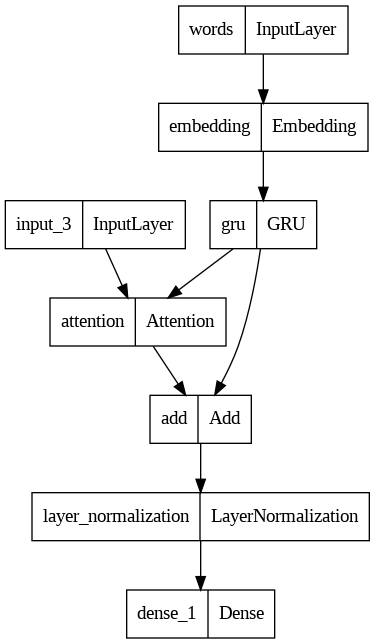

In [21]:
decoder = tf.keras.Model(
    inputs=[word_input, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)

In [22]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 512)              1024000   ['words[0][0]']               
                                                          0                                       
                                                                                                  
 gru (GRU)                   [(None, 64, 512),            1575936   ['embedding[1][0]']           
                              (None, 512)]                                                        
                                                                                            

### Training Model

Now we defined the encoder and the decoder. Let's combine them into an image model for training.<br>
It has two inputs (`image_input` and `word_input`, and an output (`decoder_output`). This definition should correspond to the definition of the dataset pipeline.

In [23]:
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)

### Loss Function
The loss function is a simple cross-entropy, but we need to remove padding (`0`) when calculating it.<br>
So here we extract the length of the sentence (non-0 part), and compute the average of the loss only over the valid sentence part.

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)

In [25]:
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

## Training loop

Now we can train the model using the standard `model.fit` API.<br>
It takes around 15-20 minutes with NVIDIA T4 GPU to train 1 epoch.

In [1]:
%%time
history = image_caption_train_model.fit(batched_ds, epochs=5)

NameError: ignored

## Caption!

The predict step is different from the training, since we need to keep track of the GRU state during the caption generation, and pass a predicted word to the decoder as an input at the next time step.

In order to do so, let's define another model for prediction while using the trained weights, so that it can keep and update the GRU state during the caption generation.

In [ ]:
gru_state_input = Input(shape=(ATTENTION_DIM), name="gru_state_input")

# Reuse trained GRU, but update it so that it can receive states.
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_atention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state],
)



1. Initialize the GRU states as zero vectors.
1. Preprocess an input image, pass it to the encoder, and extract image features.
1. Setup word tokens of `<start>` to start captioning.
1. In the for loop, we
    - pass word tokens (`dec_input`), GRU states (`gru_state`) and image features (`features`) to the prediction decoder and get predictions (`predictions`), and the updated GRU states.
    - select Top-K words from logits, and choose a word probabilistically so that we avoid computing softmax over VOCAB_SIZE-sized vector.
    - stop predicting when the model predicts the `<end>` token.
    - replace the input word token with the predicted word token for the next step.

In [ ]:
MINIMUM_SENTENCE_LENGTH = 5


## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word_to_index("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

Let's caption!

a baseball player with a catcher and umpire on top of a baseball field.
a baseball player is sliding into a base.
a baseball player swings at a pitch with the pitcher and umpire behind him.
baseball player with bat in the baseball game.
a batter in the process on the bat in a baseball game.


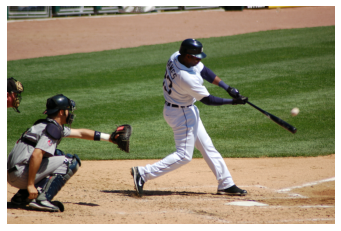

In [ ]:
filename = "../sample_images/baseball.jpeg"  # you can also try surf.jpeg

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

How does it look?<br>
It seems the model captures the key aspects of the image: people, baseball, and a ball, although it could not be grammatically perfect.

### Optional Task:
Upload your own image and generate captions with it.<br>
Also, you can try to train longer to achieve better captions.

## Summary
We learned how to build an image captioning model by creating an image encoder and a text decoder.

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.